In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cdf = pd.read_json('rs0.95-T1000_configs.json').T

In [54]:
print len(cdf)

50


In [6]:
def distance(posi,posj,box_length):
    """ return the distance between particle i and j according to the minimum image convention. """

    dist = 0.0
    if len(posi) != len(posj):
        print("Incorrect dimensions!")
        return
    ndim = len(posi)
    A = np.zeros(ndim)
    for i in range(ndim):
        d = abs(posi[i]-posj[i])
        A[i] = min(d,box_length-d)

    dist = np.linalg.norm(A)
    return dist

In [56]:
bins = {}
for idx,row in cdf.iterrows():
    axes = row['axes']
    pos  = row['pos']
    for i in range(len(pos)):
        for j in range(i,len(pos)):
            dist = round(distance(pos[i],pos[j],6.1256), 1)
            if dist>=6.1256/2:
                continue
            if dist in bins:
                bins[dist]+=1
            else:
                bins[dist]= 1

# end for

64


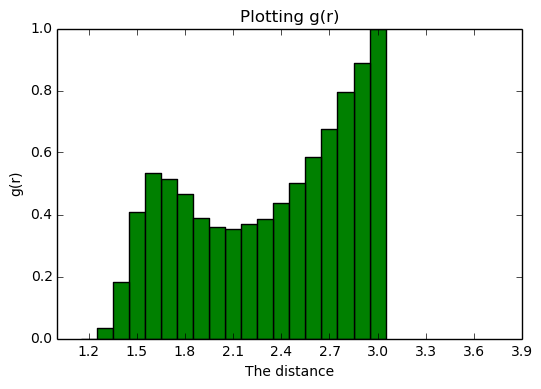

In [45]:
bins.pop(0,None)
factor=1.0/(max(bins.itervalues())-min(bins.itervalues()))
normalised_bin = {k: (v-min(bins.itervalues()))*factor for k, v in bins.iteritems()}
plt.bar(normalised_bin.keys(), normalised_bin.values(), align='center',color='g',width=0.1)
plt.title("Plotting g(r)")
plt.xlabel("The distance")
plt.ylabel("g(r)")
plt.xticks(np.arange(min(normalised_bin.keys()), max(normalised_bin.keys())+1, 0.3))
#plt.xticks(range(len(bins)), list(bins.keys()))
plt.show()

In [60]:
from itertools import product
#from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

In [40]:

def legal_kvecs(maxk):
    kvecs = []
    p=np.arange(0,maxk)
    kvecs = [x for x in product(p,repeat=3)]
    # calculate a list of legal k vectors
    return np.array(kvecs)*2*np.pi/6.1256
# end def legal_kvecs

def rhok(kvec, pset):
    value = 0.0
    #computes \sum_j \exp(i * k \dot r_j) 
    for ptcl in pset:
        value=value + np.exp(1j*np.dot(kvec,ptcl))
    return value
# end def

def Sk(kvecs, pset):
    """ computes structure factor for all k vectors in kList
     and returns a list of them """
    sk_list=[]
    for kvec in kvecs:
        sk_list.append(np.real((1.0/64)*rhok(kvec,pset)*rhok(-1*kvec,pset)).tolist())
    
    return [i/sum(sk_list) for i in sk_list]
# end def Sk

In [41]:
kvecs=legal_kvecs(5)
print kvecs
SK_list = []
for idx,row in cdf.iterrows():
    axes = row['axes']
    pos  = row['pos']
    SK_list.append(Sk(kvecs,pos))
print len(SK_list)

[[ 0.          0.          0.        ]
 [ 0.          0.          1.02572569]
 [ 0.          0.          2.05145139]
 [ 0.          0.          3.07717708]
 [ 0.          0.          4.10290277]
 [ 0.          1.02572569  0.        ]
 [ 0.          1.02572569  1.02572569]
 [ 0.          1.02572569  2.05145139]
 [ 0.          1.02572569  3.07717708]
 [ 0.          1.02572569  4.10290277]
 [ 0.          2.05145139  0.        ]
 [ 0.          2.05145139  1.02572569]
 [ 0.          2.05145139  2.05145139]
 [ 0.          2.05145139  3.07717708]
 [ 0.          2.05145139  4.10290277]
 [ 0.          3.07717708  0.        ]
 [ 0.          3.07717708  1.02572569]
 [ 0.          3.07717708  2.05145139]
 [ 0.          3.07717708  3.07717708]
 [ 0.          3.07717708  4.10290277]
 [ 0.          4.10290277  0.        ]
 [ 0.          4.10290277  1.02572569]
 [ 0.          4.10290277  2.05145139]
 [ 0.          4.10290277  3.07717708]
 [ 0.          4.10290277  4.10290277]
 [ 1.02572569  0.        

In [76]:
Sk = np.array(SK_list)
sk_list = np.mean(Sk, axis=0)
sk_list[0]=0
fact = 1.0/sk_list[len(sk_list)-1]
sk_list = [v*fact for v in sk_list]

print sk_list

[0.0, 0.0057669937784742709, 0.021697267159844338, 0.09472067304753104, 2.2290513553285174, 0.0057316147849604338, 0.0080168736492849911, 0.030408968436365005, 0.1518953131866817, 1.3274651383121387, 0.021224744554848182, 0.022620404034865923, 0.073013825773728822, 0.9994852694325822, 2.0111492193914984, 0.076916829048697247, 0.13379588119633895, 0.6833611155214856, 1.4543739285941477, 2.279138978526829, 0.92675154903081514, 1.5431507877205906, 2.4295582970639633, 1.946394297101748, 1.0745854496358616, 0.0063646606727873131, 0.010041503125257017, 0.031064154793921401, 0.12387074722964411, 1.2722474631163241, 0.010041468914777151, 0.015719173592126125, 0.03509424800819938, 0.20498652887859656, 1.6198793210613778, 0.022777831707437191, 0.042432702868465434, 0.08765633571146321, 1.7267797732300223, 2.3601005056552973, 0.13072372496882906, 0.2145769280778092, 2.352333655489967, 2.4326675909804196, 1.6553393749299872, 1.5264935832252571, 1.9036119732293966, 3.2837216071290651, 2.02113716164

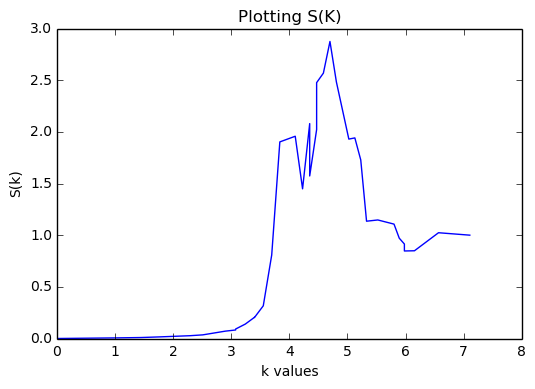

In [78]:
kmags  = [np.linalg.norm(kvec) for kvec in kvecs]
sk_arr = np.array(sk_list) # convert to numpy array if not already so 
# print sk_arr
# average S(k) if multiple k-vectors have the same magnitude
unique_kmags = np.unique(kmags)
unique_sk    = np.zeros(len(unique_kmags))
for iukmag in range(len(unique_kmags)):
    kmag    = unique_kmags[iukmag]
    idx2avg = np.where(kmags==kmag)
    unique_sk[iukmag] = np.mean(sk_arr[idx2avg])
# end for iukmag
 
# visualize
plt.plot(unique_kmags,unique_sk)
#plt.axis([0,8,0,1])
plt.xlabel("k values")
plt.ylabel("S(k)")
plt.title("Plotting S(K)")